In [1]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("world_population_data.csv")

# See first few rows to check
print(df.head())


   Year  Population Yearly % Change  Net Change  Density (P/Km²)
0  2025  8231613070           0.85%  69640498.0               55
1  2024  8161972572           0.87%  70237642.0               55
2  2023  8091734930           0.88%  70327738.0               54
3  2022  8021407192           0.84%  66958801.0               54
4  2021  7954448391           0.86%  67447099.0               53


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             93 non-null     int64  
 1   Population       93 non-null     int64  
 2   Yearly % Change  75 non-null     object 
 3   Net Change       75 non-null     float64
 4   Density (P/Km²)  93 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB


In [3]:
import pyodbc
import pandas as pd

# Connect to SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=KEROPC\SQLEXPRESS;'
    'DATABASE=world_population;'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

In [4]:
# Create table
create_table_query = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='population_data' AND xtype='U')
CREATE TABLE population_data (
    id INT IDENTITY(1,1) PRIMARY KEY,
    year INT NOT NULL,
    population BIGINT NOT NULL,
    yearly_change_percent FLOAT NULL,
    net_change BIGINT NULL,
    density_per_km2 INT
)
"""
cursor.execute(create_table_query)
conn.commit()
print(" Table created successfully!")

 Table created successfully!


In [5]:
# After conversion, drop rows that became NaN
df = df.dropna(subset=['Yearly % Change', 'Net Change'])


In [6]:

df['Yearly % Change'] = pd.to_numeric(df['Yearly % Change'].str.rstrip('%'), errors='coerce')


df['Yearly % Change'] = df['Yearly % Change'].apply(float)
df['Net Change'] = df['Net Change'].apply(float)


In [7]:
df.duplicated().sum()

0

In [8]:
df.head()

,Year,Population,Yearly % Change,Net Change,Density (P/Km²)
0,2025,8231613070,0.85,69640498.0,55
1,2024,8161972572,0.87,70237642.0,55
2,2023,8091734930,0.88,70327738.0,54
3,2022,8021407192,0.84,66958801.0,54
4,2021,7954448391,0.86,67447099.0,53


In [9]:
# Insert each row into SQL Server
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO population_data (year, population, yearly_change_percent, net_change, density_per_km2)
        VALUES (?, ?, ?, ?, ?)
    """, row['Year'], row['Population'], row['Yearly % Change'], row['Net Change'], row['Density (P/Km²)'])

# Commit and close
conn.commit()
conn.close()
print(" CSV data inserted into SQL Server successfully!")


 CSV data inserted into SQL Server successfully!


# Connect to your database

In [11]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

# --- Connection Setup ---
def get_connection():
    """Establish and return the database connection."""
    try:
        conn = pyodbc.connect(
            'DRIVER={ODBC Driver 17 for SQL Server};'
            r'SERVER=KEROPC\SQLEXPRESS;'
            'DATABASE=world_population;'
            'Trusted_Connection=yes;'
        )
        return conn
    except pyodbc.Error as e:
        print(f"❌ Connection Error: {e}")
        return None


# Population over time

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\686933.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



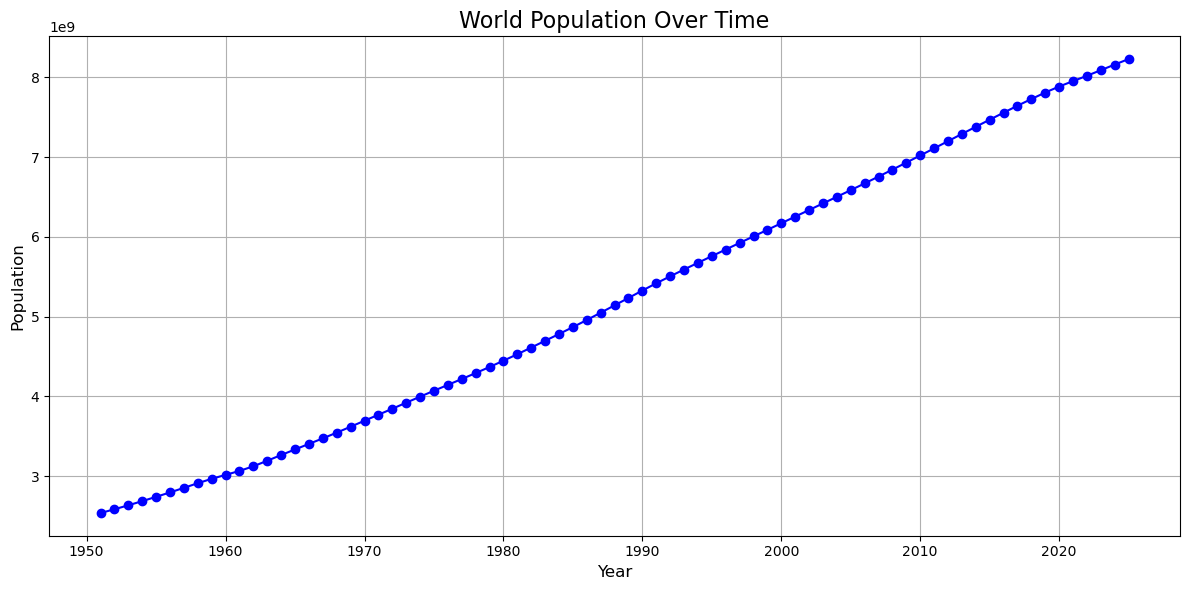

In [14]:
def visualize_population_over_time():
    conn = get_connection()
    if conn:
        with conn:
            query = """
                SELECT year, population
                FROM population_data
                ORDER BY year ASC
            """
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                plt.figure(figsize=(12,6))
                plt.plot(df['year'], df['population'], marker='o', color='blue')
                plt.title('World Population Over Time', fontsize=16)
                plt.xlabel('Year', fontsize=12)
                plt.ylabel('Population', fontsize=12)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print("No population data found.")
visualize_population_over_time()

# Top 5 Years by Yearly Growth %

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\2780072347.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



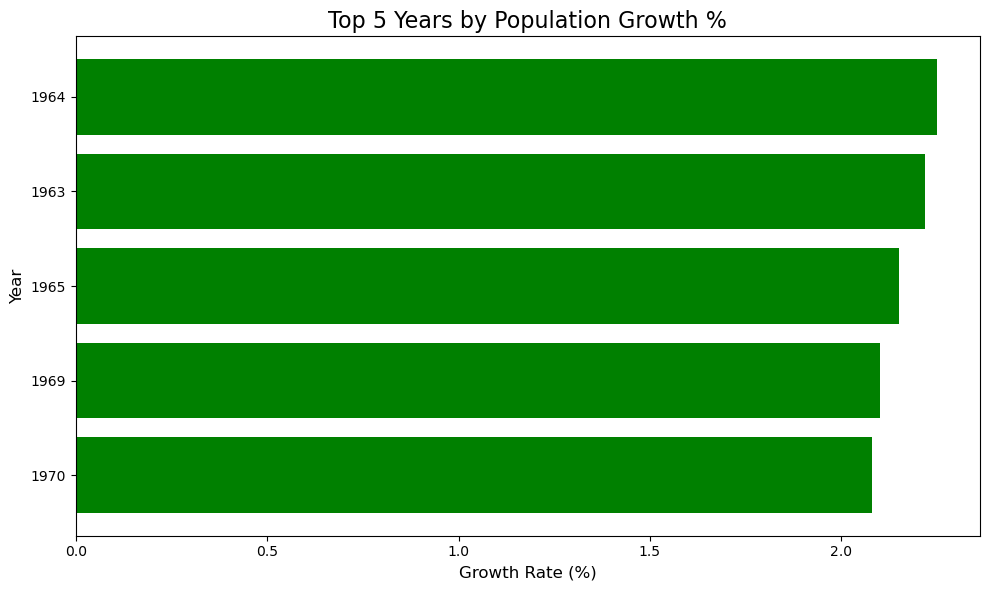

In [15]:
def visualize_top_growth_years():
    conn = get_connection()
    if conn:
        with conn:
            query = """
                SELECT TOP 5 year, [yearly_change_percent]
                FROM population_data
                ORDER BY [yearly_change_percent] DESC
            """
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                df = df.sort_values(by='yearly_change_percent', ascending=True)
                plt.figure(figsize=(10,6))
                plt.barh(df['year'].astype(str), df['yearly_change_percent'], color='green')
                plt.title('Top 5 Years by Population Growth %', fontsize=16)
                plt.xlabel('Growth Rate (%)', fontsize=12)
                plt.ylabel('Year', fontsize=12)
                plt.tight_layout()
                plt.show()
            else:
                print("No growth data found.")
visualize_top_growth_years()

# Top 10 Years with Highest Population (Bar Chart)

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\3179300941.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



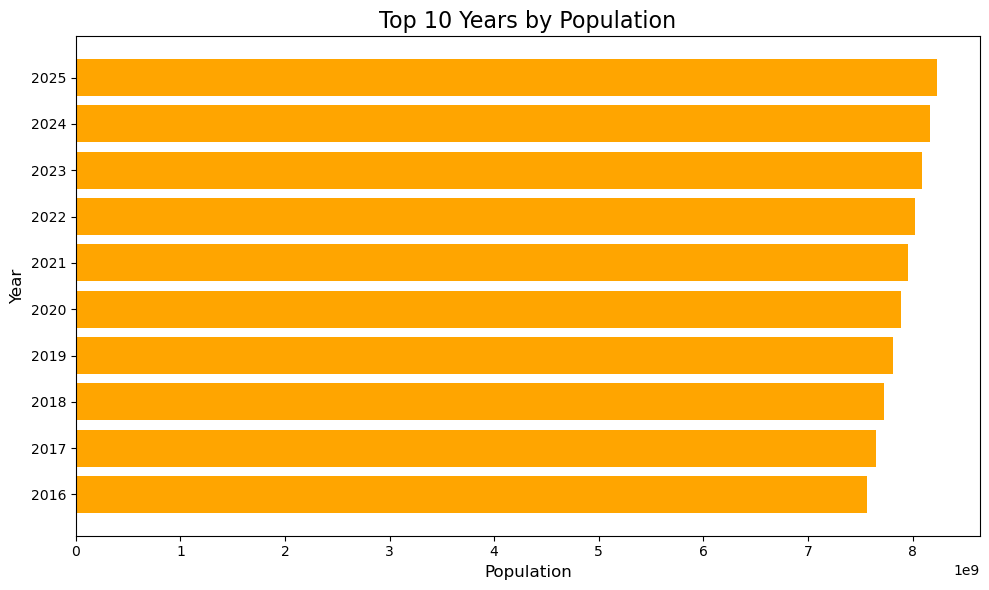

In [16]:
def top_population_years():
    conn = get_connection()
    if conn:
        with conn:
            query = """
                SELECT TOP 10 year, population
                FROM population_data
                ORDER BY population DESC
            """
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                df = df.sort_values('population')  # for horizontal bar chart
                plt.figure(figsize=(10,6))
                plt.barh(df['year'].astype(str), df['population'], color='orange')
                plt.title('Top 10 Years by Population', fontsize=16)
                plt.xlabel('Population', fontsize=12)
                plt.ylabel('Year', fontsize=12)
                plt.tight_layout()
                plt.show()
top_population_years()

# Biggest Year-to-Year Population Increase (Net Change) – Horizontal Bar Chart

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\2334010708.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



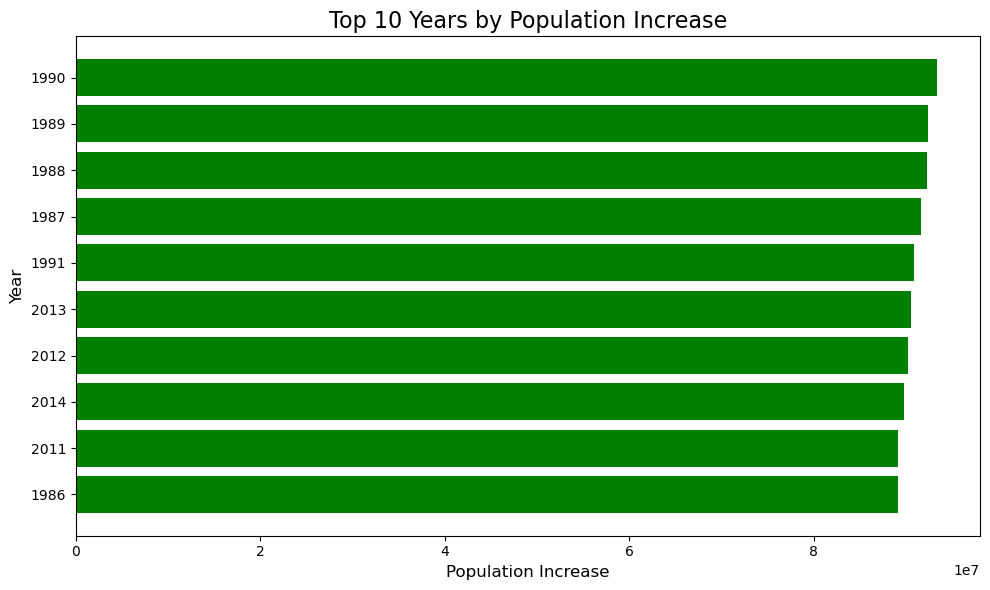

In [17]:
def top_population_increase_years():
    conn = get_connection()
    if conn:
        with conn:
            query = """
                SELECT TOP 10 year, net_change
                FROM population_data
                ORDER BY net_change DESC
            """
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                df = df.sort_values('net_change')
                plt.figure(figsize=(10,6))
                plt.barh(df['year'].astype(str), df['net_change'], color='green')
                plt.title('Top 10 Years by Population Increase', fontsize=16)
                plt.xlabel('Population Increase', fontsize=12)
                plt.ylabel('Year', fontsize=12)
                plt.tight_layout()
                plt.show()
top_population_increase_years()

# Population Growth Rate Over Time (Line + Highlight Top Years)

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\111549641.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



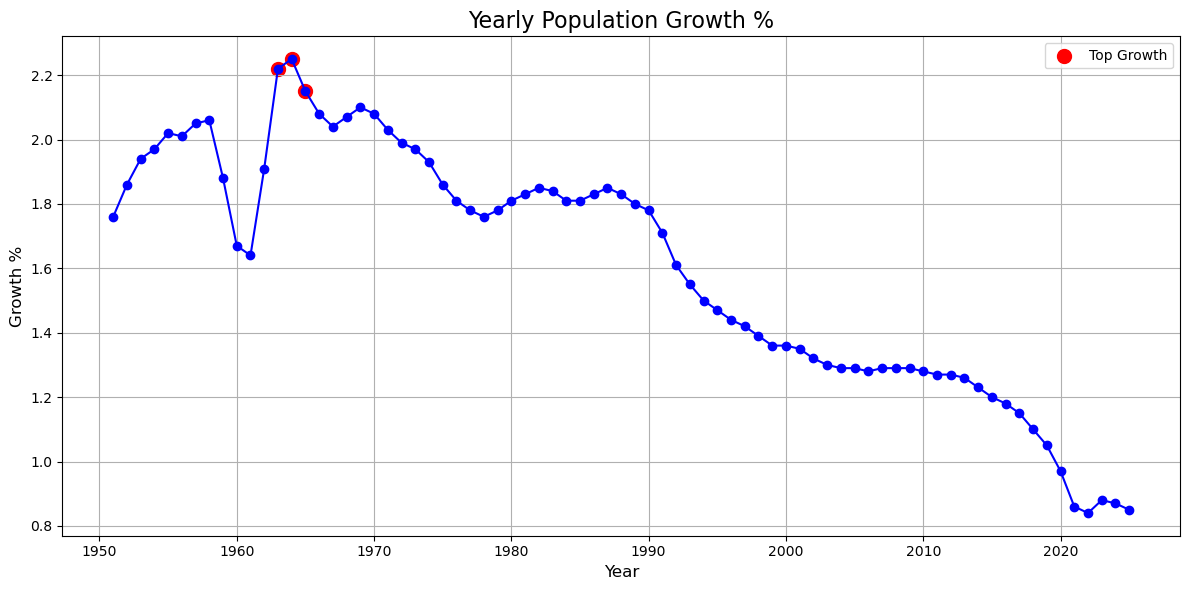

In [18]:
def growth_rate_line_chart():
    conn = get_connection()
    if conn:
        with conn:
            query = "SELECT year, yearly_change_percent FROM population_data ORDER BY year ASC"
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                plt.figure(figsize=(12,6))
                plt.plot(df['year'], df['yearly_change_percent'], color='blue', marker='o')
                
                # Highlight top 3 growth years
                top3 = df.nlargest(3, 'yearly_change_percent')
                plt.scatter(top3['year'], top3['yearly_change_percent'], color='red', s=100, label='Top Growth')
                
                plt.title('Yearly Population Growth %', fontsize=16)
                plt.xlabel('Year', fontsize=12)
                plt.ylabel('Growth %', fontsize=12)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
growth_rate_line_chart()

# Population vs. Density Over Time (Dual Axis Line Chart)

C:\Users\HP\AppData\Local\Temp\ipykernel_20980\4078447414.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



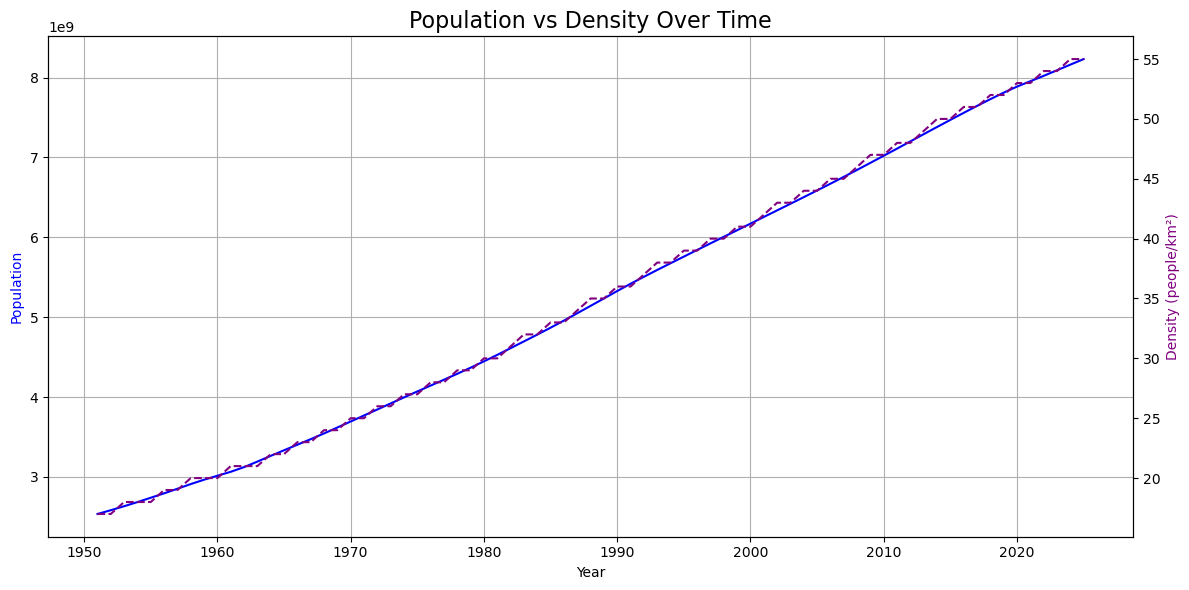

In [19]:
def population_vs_density():
    conn = get_connection()
    if conn:
        with conn:
            query = "SELECT year, population, density_per_km2 FROM population_data ORDER BY year ASC"
            df = pd.read_sql(query, conn)
            
            if not df.empty:
                fig, ax1 = plt.subplots(figsize=(12,6))
                
                ax1.plot(df['year'], df['population'], color='blue', label='Population')
                ax1.set_xlabel('Year')
                ax1.set_ylabel('Population', color='blue')
                
                ax2 = ax1.twinx()
                ax2.plot(df['year'], df['density_per_km2'], color='purple', linestyle='--', label='Density')
                ax2.set_ylabel('Density (people/km²)', color='purple')
                
                plt.title('Population vs Density Over Time', fontsize=16)
                fig.tight_layout()
                ax1.grid(True)
                plt.show()
population_vs_density()